In [12]:
using Agents
using StatsBase: mean

In [13]:
mutable struct SchellingAgent <: AbstractAgent
    id::Int # The identifier number of the agent
    pos::Dims{2} # The x, y location of the agent on a 2D grid
    mood::Bool # whether the agent is happy in its position. (true = happy)
    group::Int # The group of the agent,  determines mood as it interacts with neighbors
end

In [16]:
@agent SchellingAgent GridAgent{2} begin
    mood::Bool
    group::Int
end

In [5]:
space = GridSpace((10, 10), periodic = false)

GridSpace with size (10, 10), metric=chebyshev and periodic=false

In [17]:
properties = Dict(:min_to_be_happy => 1)
schelling = ABM(SchellingAgent, space; properties)

AgentBasedModel with 0 agents of type SchellingAgent
 space: GridSpace with size (10, 10), metric=chebyshev and periodic=false
 scheduler: fastest
 properties: Dict(:min_to_be_happy => 1)

In [18]:
using Random # for reproducibility

function initialize(; numagents = 320, griddims = (20, 20), min_to_be_happy = 3, seed = 125)
    space = GridSpace(griddims, periodic = false)
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Random.MersenneTwister(seed)
    model = ABM(
        SchellingAgent, space;
        properties # , rng, scheduler = random_activation
    )

    # populate the model with agents, adding equal amount of the two types of agents
    # at random positions in the model
    for n in 1:numagents
        agent = SchellingAgent(n, (1, 1), false, n < numagents / 2 ? 1 : 2)
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [19]:
function agent_step!(agent, model)
    agent.mood == true && return # do nothing if already happy
    minhappy = model.min_to_be_happy
    neighbor_positions = nearby_positions(agent, model)
    count_neighbors_same_group = 0
    # For each neighbor, get group and compare to current agent's group
    # and increment count_neighbors_same_group as appropriately.
    for neighbor in nearby_agents(agent, model)
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    # After counting the neighbors, decide whether or not to move the agent.
    # If count_neighbors_same_group is at least the min_to_be_happy, set the
    # mood to true. Otherwise, move the agent to a random position.
    if count_neighbors_same_group ≥ minhappy
        agent.mood = true
    else
        move_agent_single!(agent, model)
    end
    return
end

agent_step! (generic function with 1 method)

In [20]:
model = initialize()

AgentBasedModel with 320 agents of type SchellingAgent
 space: GridSpace with size (20, 20), metric=chebyshev and periodic=false
 scheduler: fastest
 properties: Dict(:min_to_be_happy => 3)

In [21]:
adata = [:pos, :mood, :group]

model = initialize()
data, _ = run!(model, agent_step!, 5; adata)
data[1:10, :] # print only a few rows

,step,id,pos,mood,group
,Int64,Int64,Tuple…,Bool,Int64
1,0,1,"(2, 1)",0,1
2,0,2,"(20, 9)",0,1
3,0,3,"(7, 13)",0,1
4,0,4,"(15, 2)",0,1
5,0,5,"(8, 13)",0,1
6,0,6,"(5, 17)",0,1
7,0,7,"(12, 16)",0,1
8,0,8,"(20, 13)",0,1
9,0,9,"(1, 1)",0,1


In [ ]:
using InteractiveDynamics
import CairoMakie # choosing a plotting backend

┌ Info: Precompiling InteractiveDynamics [ec714cd0-5f51-11eb-0b6e-452e7367ff84]
└ @ Base loading.jl:1278
┌ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
└ @ Base loading.jl:1278


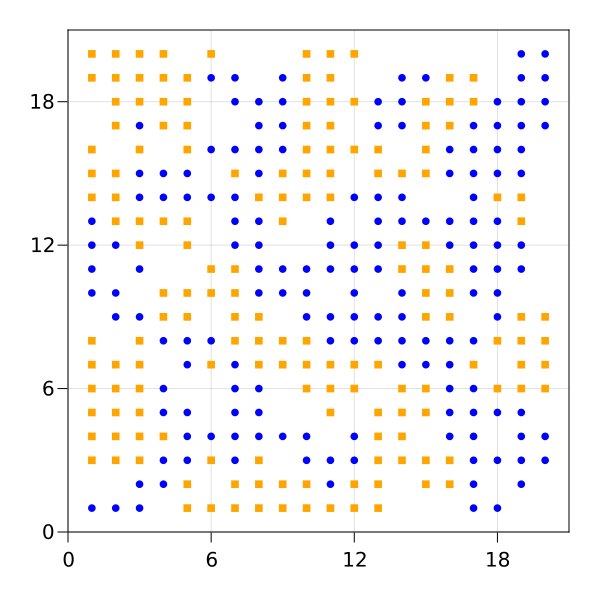

In [11]:
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect
figure, _ = abm_plot(model; ac = groupcolor, am = groupmarker, as = 10)
figure # returning the figure displays it

In [60]:
model = initialize();
abm_video(
    "schelling.mp4", model, agent_step!;
    ac = groupcolor, am = groupmarker, as = 10,
    framerate = 4, frames = 20,
    title = "Schelling's segregation model"
)